In [1]:
import jax
from jax import jit
import timeit
import jax.numpy as jnp
import numpy as np
from ott.geometry import pointcloud
from lower_bound import histogram_distances
import seaborn as sns
import matplotlib.pyplot as plt

from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein
from ott.solvers.linear import sinkhorn
from ott.geometry.geometry import Geometry

In [2]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


In [3]:
# Data parameters
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3

# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = jax.random.split(key, 4)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# apply Gromov-Wasserstein
def gromov_wass(geom_xx, geom_yy, epsilon):
    prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)
    solver = gromov_wasserstein.GromovWasserstein(epsilon=epsilon, max_iterations=20)
    ot = solver(prob)
    return ot


In [7]:
distance_fn = jax.jit(lambda x, y: histogram_distances(x, y, p = 2))
solve_fn = jax.jit(sinkhorn.solve)

def lower_bound(geom_xx, geom_yy):
    xy_dist = distance_fn(geom_xx, geom_yy)
    geom_xy = Geometry(cost_matrix=xy_dist, epsilon = .05)
    ot = solve_fn(geom_xy)
    return ot


N = 100
n_spiral = N
n_swiss_roll = N

spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)
geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)

In [11]:
N_s = (np.exp(np.arange(1, 6., step = 0.5))).astype(np.int32)
epsilons = [10., 100., 1000.]
trials = 5
lower_bound_avg_times = []
gromov_wass_low_entropy_avg_times = []
gromov_wass_med_entropy_avg_times = []
gromov_wass_high_entropy_avg_times = []
for N in N_s:
    n_spiral = N
    n_swiss_roll = N

    spiral = sample_spiral(
        n_spiral,
        min_radius,
        max_radius,
        key=subkey[0],
        min_angle=min_angle + angle_shift,
        max_angle=max_angle + angle_shift,
        noise=noise,
    )
    swiss_roll = sample_swiss_roll(
        n_swiss_roll,
        min_radius,
        max_radius,
        key=subkey[1:],
        length=length,
        min_angle=min_angle,
        max_angle=max_angle,
    )
    geom_xx = pointcloud.PointCloud(x=spiral, y=spiral)
    geom_yy = pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)

    lower_bound_avg_times.append(
        timeit.timeit("lower_bound(geom_xx, geom_yy)", globals = globals(), number = trials) / trials
    )
    gromov_wass_low_entropy_avg_times.append(
        timeit.timeit("gromov_wass(geom_xx, geom_yy, epsilons[0])", globals = globals(), number = trials) / trials
    )
    gromov_wass_med_entropy_avg_times.append(
        timeit.timeit("gromov_wass(geom_xx, geom_yy, epsilons[1])", globals = globals(), number = trials) / trials
    )
    gromov_wass_high_entropy_avg_times.append(
        timeit.timeit("gromov_wass(geom_xx, geom_yy, epsilons[2])", globals = globals(), number = trials) / trials
    )

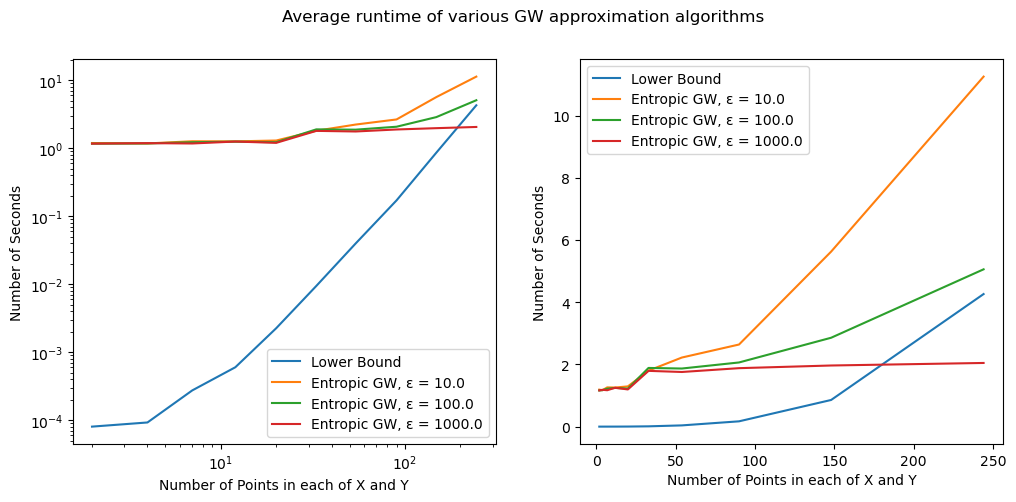

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

sns.lineplot(x = N_s, y = lower_bound_avg_times, label = "Lower Bound", ax = axs[0])
sns.lineplot(x = N_s, y = gromov_wass_low_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[0]}", ax = axs[0])
sns.lineplot(x = N_s, y = gromov_wass_med_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[1]}", ax = axs[0])
sns.lineplot(x = N_s, y = gromov_wass_high_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[2]}", ax = axs[0])

sns.lineplot(x = N_s, y = lower_bound_avg_times, label = "Lower Bound", ax = axs[1])
sns.lineplot(x = N_s, y = gromov_wass_low_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[0]}", ax = axs[1])
sns.lineplot(x = N_s, y = gromov_wass_med_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[1]}", ax = axs[1])
sns.lineplot(x = N_s, y = gromov_wass_high_entropy_avg_times, label = f"Entropic GW, \u03b5 = {epsilons[2]}", ax = axs[1])

axs[0].set(
    xlabel = "Number of Points in each of X and Y",
    ylabel = "Number of Seconds",
    yscale = "log",
    xscale = "log"
)
axs[1].set(
    xlabel = "Number of Points in each of X and Y",
    ylabel = "Number of Seconds",
    # yscale = "log",
    # xscale = "log"
)

fig.suptitle("Average runtime of various GW approximation algorithms")

plt.show()

In [18]:
lower_bound_out = lower_bound(geom_xx, geom_yy)
gromov_wass_out = gromov_wass(geom_xx, geom_yy, 2_000.)

<Axes: >

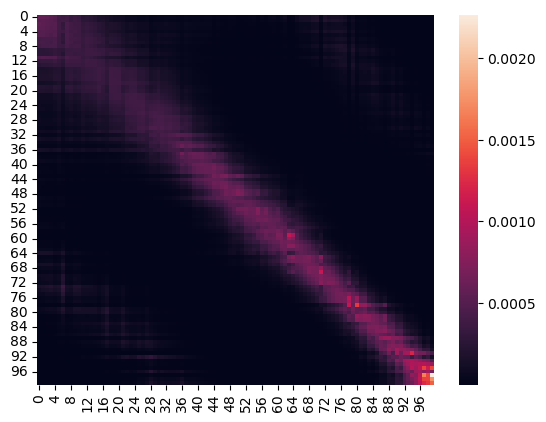

In [19]:
# sns.heatmap(lower_bound_out.matrix)
sns.heatmap(gromov_wass_out.matrix)